**Brian Blaylock**  
**November 21, 2018**

# Cartopy Tutorial

I am told Basemap should no longer be used for making maps in Python. That's too bad, becuase I am very familiar with it. About every six months I try to learn Cartopy and use it, but haven't been able to abandon Basemap for Cartopy. Cartopy is missing some things, like US boundaries and US counties built into it. I will, however, figure this out sooner or later. This notebook is my sandbox where I am trying to figure out how to use Cartopy

### Introduction remarks
Begin by importing the Cartopy Coordinate Reference System (CCRS) and the features library. 

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

- The `crs` submodule stands for the Coordinate Reference System and defines the Coordinate Reference Systems and the transformations between them.
- The `feature` submodule is used to draw state and country outlines.

If you want to draw county lines, you will need to draw those yourself from a shape file, or import a module from metpy. Make sure you are using version 0.9 or later.

    from metpy.plots import USCOUNTIES

    

### Resources
- [Cartopy Documentation](https://scitools.org.uk/cartopy/docs/latest/)
    - [Cartopy Advanced mapping](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html)
- [Tutorial by Nathan Wendt](https://github.com/nawendt/cartopy-tutorial)
- [MetPy Counties Lines](https://unidata.github.io/MetPy/latest/examples/plots/US_Counties.html#sphx-glr-examples-plots-us-counties-py)


### Issues I have run into
- Cannot label gridlines on a LambertConformal plot.  Only PlateCarree and Mercator plots are currently supported.
- Transforming an imshow image from one map projection to antoher is either extreamly slow or doesn't work at all.
- To add a colorbar, you must explicitly reference the object and the axis. For example `plt.colorbar(cs, ax=ax)` where cs is a ax.pcolormesh or ax.contour object and ax is the figure axes.
- Map extent for HRRR `pcolormesh` objects to not auto scale correctly.
- Can not easily add a background image from ArcGIS servers.
- Can not draw county lines on same resolution as state and country boundaries.

> NOTE: you cannot use `pcolormesh` and `cartopy` together with `matplotlib 3.0.0`. Upgrade matplotlib to version `3.0.1` or higher.

---

#### Load necessary modules...

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

# pyproj is used to georeference GOES-16 latitude and longitude coordinates
from pyproj import Proj

#### Load data from the High-Resolution Rapid Refresh (HRRR) Model

In [6]:
gust = np.load('./data/HRRR_F00_20181010-1400_GUST-surface.npy').item()
print(gust.keys())

dict_keys(['value', 'lat', 'lon', 'valid', 'anlys', 'msg', 'name', 'units', 'level', 'URL'])


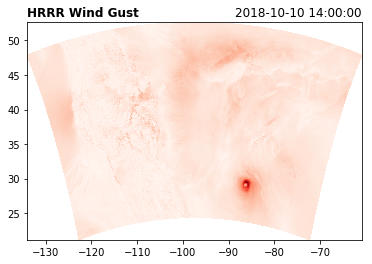

In [7]:
# Plot the raw data on a flat map
plt.pcolormesh(gust['lon'], gust['lat'], gust['value'], cmap='Reds')
plt.title('HRRR Wind Gust', fontweight='semibold', loc='left')
plt.title(gust['valid'], loc='right');

# HRRR Lambert Conformal Projection

From HRRR [namelist.wps](https://rapidrefresh.noaa.gov/hrrr/HRRR/static/HRRRv3/conus/)
>dx = 3000,  
 dy = 3000,  
 map_proj =  'lambert',  
 ref_lat   = 38.5,  
 ref_lon   = -97.5,  
 truelat1  = 38.5,  
 truelat2  = 38.5,  
 stand_lon = -97.5,  

- central_latitude  : 38.5 (same as lat_0 in proj4) 
- central_longitude : -97.5 (same as lon_0)
- standard_parallels: (38.5, 38.5) (same as lat_1, lat_2)

> NOTE: use the **DictName to apply all the dictionary keys to the function arguments

#### Create HRRR projection objection

In [8]:
# Create a Cartopy projection object

lccProjParams_HRRR = { 'central_latitude'   : -38.5,        # same as lat_0 in proj4 string 
                       'central_longitude'  : -97.5,        # same as lon_0
                       'standard_parallels' : (38.5, 38.5), # same as (lat_1, lat_2)
                     }

HRRR_proj = ccrs.LambertConformal(**lccProjParams_HRRR)

#### Plot HRRR data on HRRR projection: Contourf

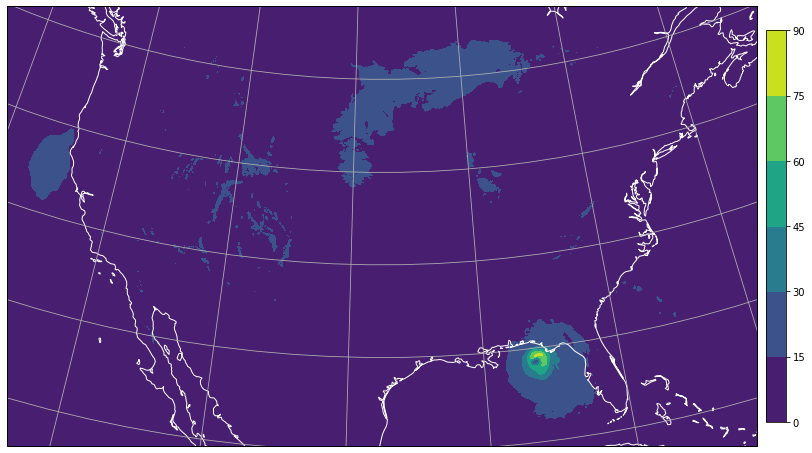

In [10]:
fig = plt.figure(figsize=(16,9))

# "destination" projection.
# In other words, the projection of the figure axes, the projection that will be displayed.
ax = plt.axes(projection=HRRR_proj)

# "source" projection
# Since we have latitude/longitude points for every data point, we use PlateCarree.
cf = ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

plt.colorbar(cf, ax=ax, shrink=.8, pad=.01)

ax.coastlines(resolution='50m', color='w')

ax.gridlines()

## Draw the entire globe (do not auto scale)
#ax.set_global()

#### Plot HRRR data on HRRR projection: pcolormesh
The same as above, but with pcolormesh...but why doesn't the figure auto scale the extent?

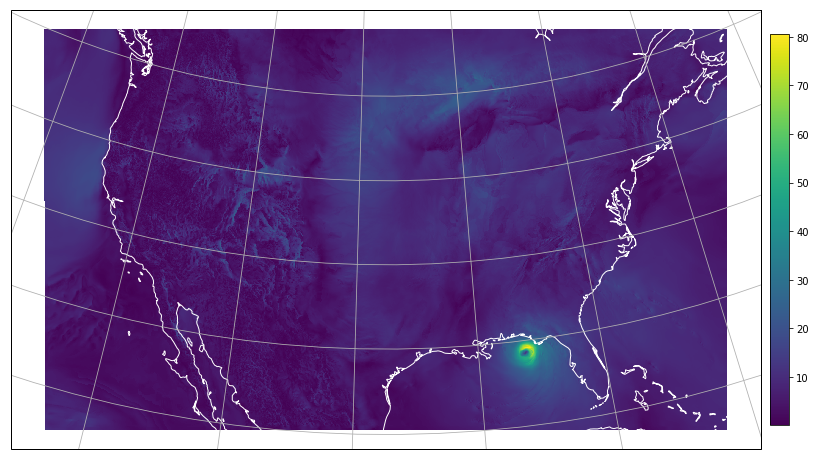

In [64]:
fig = plt.figure(figsize=(16,9))

# "destination" projection.
# In other words, the projection of the figure axes, the projection that will be displayed.
ax = plt.axes(projection=HRRR_proj)

# "source" projection
# Since we have latitude/longitude points for every data point, we use PlateCarree.
cf = ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

plt.colorbar(cf, ax=ax, shrink=.8, pad=.01)

ax.coastlines(resolution='50m', color='w')

ax.gridlines()

## Draw the entire globe (do not auto scale)
#ax.set_global()

---
---

### Load some GOES-16 
Generate RGB array and RGB color tuple for pcolormesh. See GOES-16 true color tutorial.

In [14]:
C = xarray.open_dataset('./data/OR_ABI-L2-MCMIPC-M3_G16_s20182831437203_e20182831439576_c20182831440087.nc')

# True Color RGB
#-----------------------------
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply a gamma correction to the image
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

## Put together the RGB
RGB = np.dstack([R, G_true, B])


# Color tuple for pcolormesh
#-----------------------------
# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

C:\ProgramData\Anaconda3\envs\pyBKB_v3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in maximum
C:\ProgramData\Anaconda3\envs\pyBKB_v3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum


In [15]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

print('Central Longitude', sat_lon)
print('Satellite_height', sat_h)
print('sweep_axis', sat_sweep)

# Generate latitude/longitude grid
#-----------------------------
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

Central Longitude -75.0
Satellite_height 35786023.0
sweep_axis x


# GOES-16 Geostationary Projection Cartopy Object

In [16]:
geostationayProjParams_GOES16 = {'central_longitude' : sat_lon,
                                 'satellite_height' : sat_h,
                                 'sweep_axis' : sat_sweep
                                }

GOES16_proj = ccrs.Geostationary(**geostationayProjParams_GOES16)

Simply plot the GOES data (single channel) with `imshow` onto the axes with geostationary projection

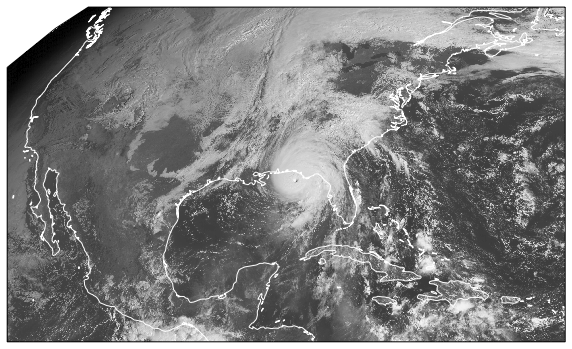

In [20]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=GOES16_proj)

ax.imshow(R, origin='upper', cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))

ax.coastlines(resolution='50m', color='w')

Now plot the data and show the full disk...and use `pcolormesh` with the lat/lon grids.

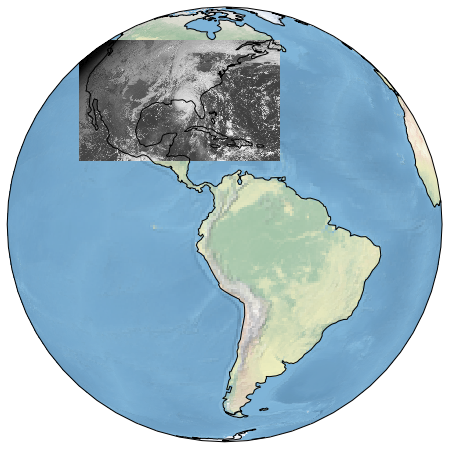

In [23]:
# GOES on GOES projection
fig = plt.figure(figsize=(8,8))

# "destination" projection
ax = plt.axes(projection=GOES16_proj)

ax.pcolormesh(lons, lats, R, cmap='Greys_r', transform=ccrs.PlateCarree())

ax.coastlines(resolution='110m')
#ax.coastlines(resolution='50m')
#ax.coastlines(resolution='10m')

ax.set_global()

ax.stock_img()

Plot RGB with `imshow` on geostationary disk.

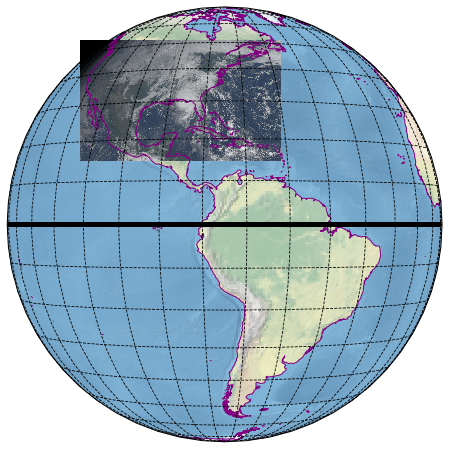

In [24]:
# GOES on GOES projection
fig = plt.figure(figsize=(8,8))

# "destination" projection
ax = plt.axes(projection=GOES16_proj)

ax.stock_img()

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=GOES16_proj)

ax.coastlines(resolution='50m', color='purple')

ax.set_global()

ax.gridlines(xlocs=range(0,361,10), ylocs=range(-90,90,10), color='k', linestyle='--')
ax.gridlines(ylocs=[0], color='k', linewidth=5)

### Plot GOES-16 red channel on HRRR projection
Must use pcolormesh because transforming an imshow figure to a different coordinate system is extreamly slow.

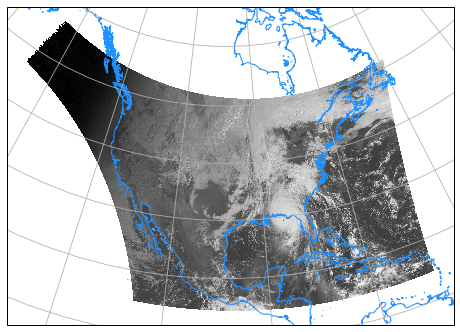

In [27]:
# GOES on HRRR Projection
fig = plt.figure(figsize=(8,8))

# "destination" projection
ax = plt.axes(projection=HRRR_proj)

# "Source" projection
ax.pcolormesh(lons, lats, R, cmap='Greys_r', transform=ccrs.PlateCarree())

ax.coastlines(resolution='10m', color='dodgerblue')

#ax.set_global()

ax.gridlines()

### GOES on HRRR projection, zoom in on Hurricane Michael
Also, plot location of maximum wind speed.

In [28]:
hrrr_max_gust = np.nanmax(gust['value'])
index_max_gust = np.where(gust['value']==hrrr_max_gust)
lon_max_gust = gust['lon'][index_max_gust]
lat_max_gust = gust['lat'][index_max_gust]

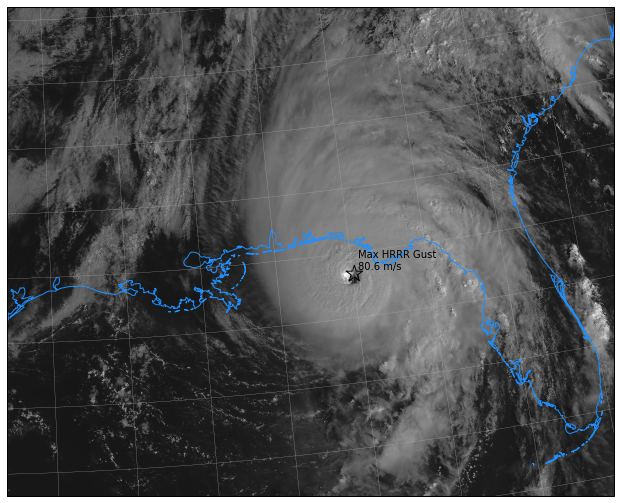

In [29]:
# GOES on HRRR Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=HRRR_proj)

# "Source" projection
ax.pcolormesh(lons, lats, C['CMI_C01'], cmap='Greys_r', transform=ccrs.PlateCarree())

ax.scatter(lon_max_gust, lat_max_gust,
           facecolor='none',
           edgecolor='k',
           marker='*',
           s=300,
           transform=ccrs.PlateCarree())

ax.text(lon_max_gust+.1, lat_max_gust+.1, 'Max HRRR Gust\n%.1f m/s' % hrrr_max_gust,
        transform=ccrs.PlateCarree())

ax.coastlines(resolution='10m', color='dodgerblue')

# Zoom on location on map
ax.set_extent([-95, -80, 25, 35])

ax.gridlines(linewidth=.25)

### GOES on HRRR projection with HRRR gust contours overlay

Text(1.0, 1.0, 'GOES16 2018-10-10 14:00:00\nHRRR Gusts 2018-10-10 14:00:00')

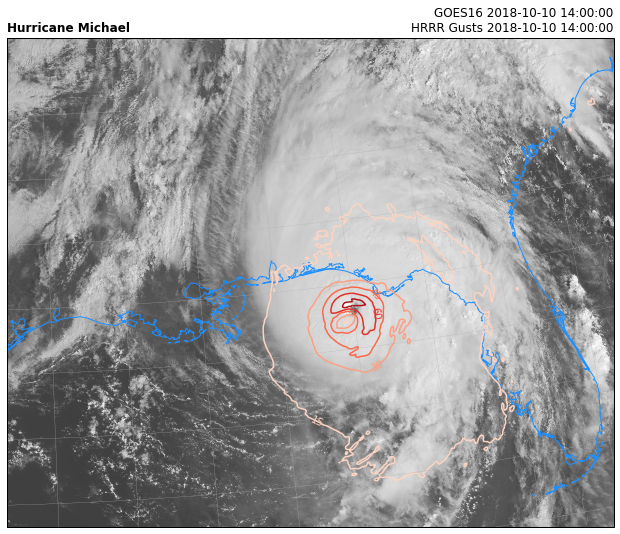

In [31]:
# GOES on HRRR projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=HRRR_proj)

# "Source" projection
ax.pcolormesh(lons, lats, R, cmap='Greys_r', transform=ccrs.PlateCarree())

cs = ax.contour(gust['lon'], gust['lat'], gust['value'],
                cmap='Reds', 
                transform=ccrs.PlateCarree())
plt.clabel(cs, inline_spacing=.001, fmt='%.f', inline=False)

ax.coastlines(resolution='10m', color='dodgerblue')

ax.set_extent([-95, -80, 25, 35])
ax.gridlines(linewidth=.25)

plt.title('Hurricane Michael', loc='left', fontweight='bold')
plt.title('GOES16 %s\nHRRR Gusts %s' % (gust['valid'], gust['valid']), loc='right')

---
`imshow` transforms are either extreamly slow or do not work.
(i.e. transforming a RGB from it's geostationary projection to the HRRR projection)


In [ ]:
# Transforming an image from one projection to another is extreamly slow or doesn't work for imshow.
'''
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "Source" projection
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=GOES16_proj)

ax.coastlines(resolution='110m', color='dodgerblue')

#ax.set_global()
#ax.set_extent([-95, -80, 25, 35])
ax.gridlines()
'''

We still have to use the color tuple method with pcolormesh.

### GOES RGB on HRRR projection with pcolormesh

C:\ProgramData\Anaconda3\envs\pyBKB_v3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\ProgramData\Anaconda3\envs\pyBKB_v3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


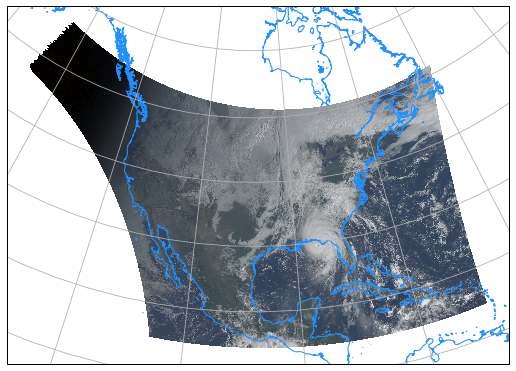

In [32]:
# GOES on HRRR Projection
fig = plt.figure(figsize=(9,9))

# "destination" projection
ax = plt.axes(projection=HRRR_proj)

# "Source" projection
newmap = ax.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, transform=ccrs.PlateCarree())
newmap.set_array(None)

ax.coastlines(resolution='10m', color='dodgerblue')

ax.gridlines()

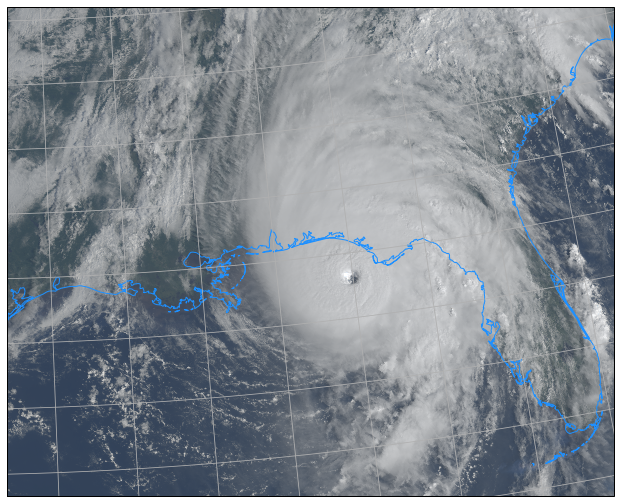

In [33]:
# GOES on HRRR projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=HRRR_proj)

# "Source" projection
newmap = ax.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, transform=ccrs.PlateCarree())
newmap.set_array(None)

ax.coastlines(resolution='10m', color='dodgerblue')

ax.set_extent([-95, -80, 25, 35])
ax.gridlines()

### HRRR on Geostationary projection

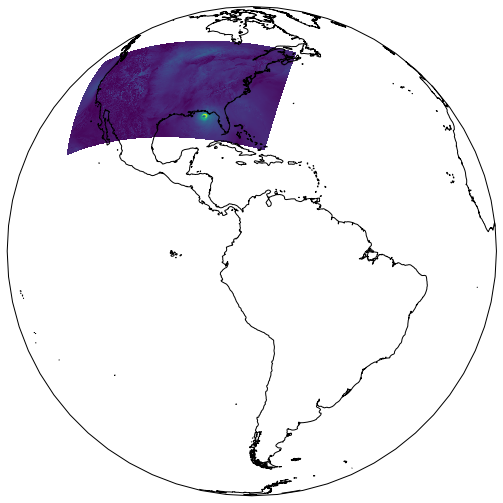

In [34]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=GOES16_proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
#ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')

ax.set_global()

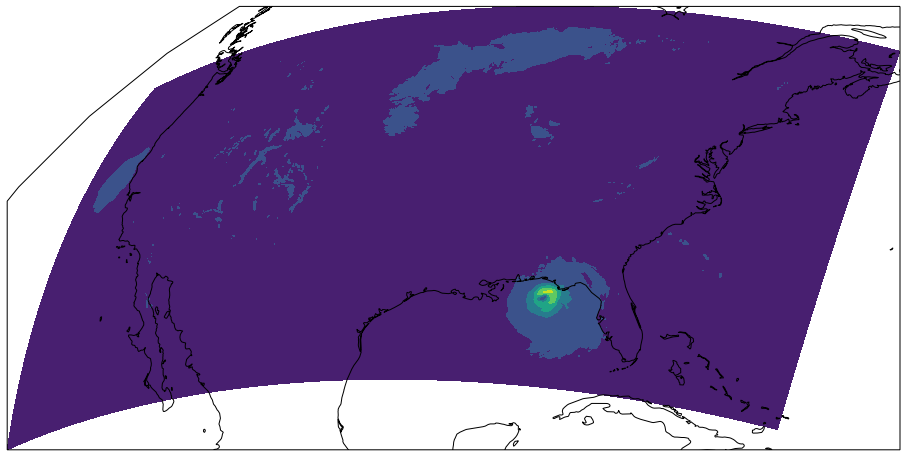

In [36]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=GOES16_proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
#ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')

#ax.set_global()

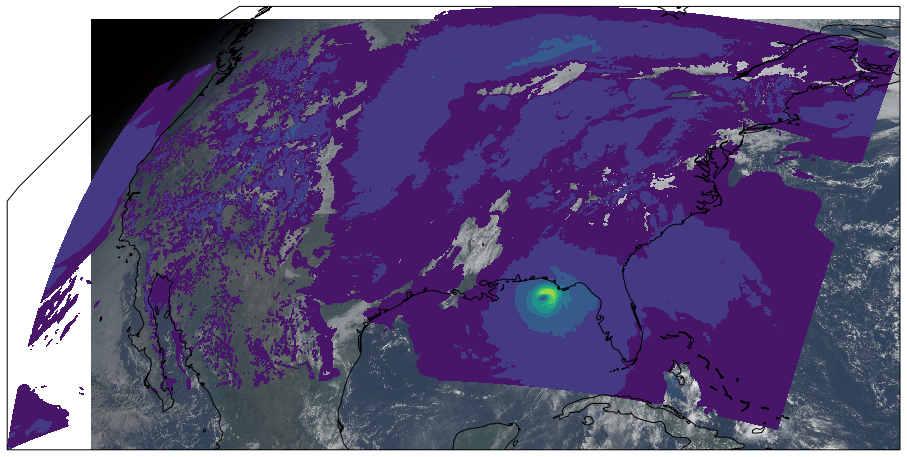

In [43]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection=GOES16_proj)

# "source" projection

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=GOES16_proj)

# Since we have lat/lon points for every data point, we use PlateCarree
#ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
# Mask gusts less than 5 m/s, so we can see through some of the plot, but still still the extent of the HRRR domain
masked = np.ma.array(gust['value'], mask=gust['value']<5)
ax.contourf(gust['lon'], gust['lat'], masked, transform=ccrs.PlateCarree())


ax.coastlines(resolution='50m')

#ax.set_global()

# MetPy County Lines
NOTE: The highest resolution plots takes a long time, especially if you plot a large spatial area.

In [8]:
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.

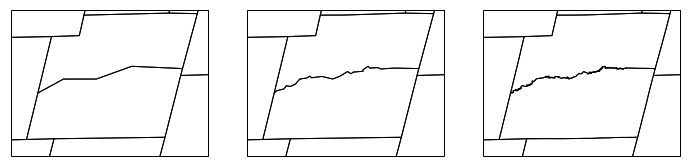

In [10]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(1, 3, 1, projection=GOES16_proj)
ax2 = fig.add_subplot(1, 3, 2, projection=GOES16_proj)
ax3 = fig.add_subplot(1, 3, 3, projection=GOES16_proj)

for scale, axis in zip(['20m', '5m', '500k'], [ax1, ax2, ax3]):
    axis.set_extent([270.25, 270.9, 38.15, 38.75], ccrs.Geodetic())
    axis.add_feature(USCOUNTIES.with_scale(scale), edgecolor='black')

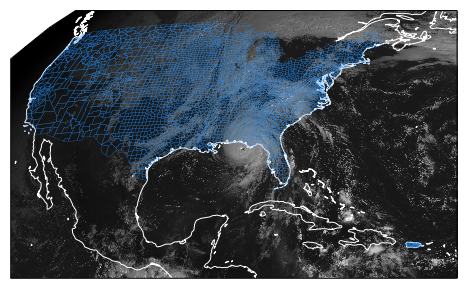

In [12]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = GOES16_proj)
ax.coastlines('50m', color='w')
ax.imshow(C['CMI_C01'], origin='upper', cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='dodgerblue', linewidth=.2)

# Cartopy Web Map Services (WMS)

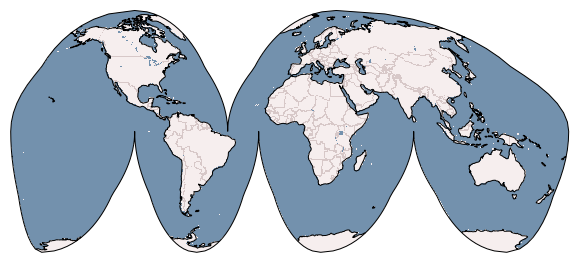

In [3]:
# Tutorial: https://predictablynoisy.com/cartopy/gallery/web_services/wms.html
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.InterruptedGoodeHomolosine())
ax.coastlines()

ax.add_wms(wms='http://vmap0.tiles.osgeo.org/wms/vmap0',
           layers=['basic'])

plt.show()

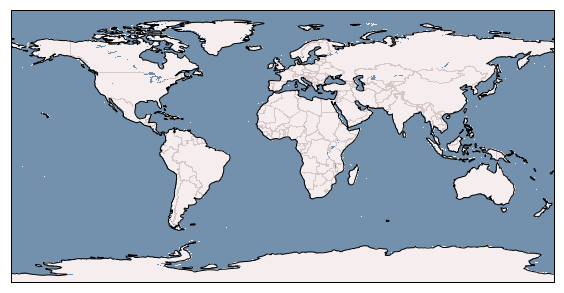

In [4]:
# Tutorial: https://predictablynoisy.com/cartopy/gallery/web_services/wms.html
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_wms(wms='http://vmap0.tiles.osgeo.org/wms/vmap0',
           layers=['basic'])

plt.show()

## NEXRAD moasic from Iowa State University

`.png` image served as a Web Map Service. See the below URL for colromap.

Source: https://mesonet.agron.iastate.edu/docs/nexrad_composites/

Available at 5-min intervals.

- **N0R**: Base Reflectivity - 4 bit/5 dbz resolution (_depreciated?_)
- **N0Q**: Base Reflectivity - 8 bit/0.5 dbz resoltion


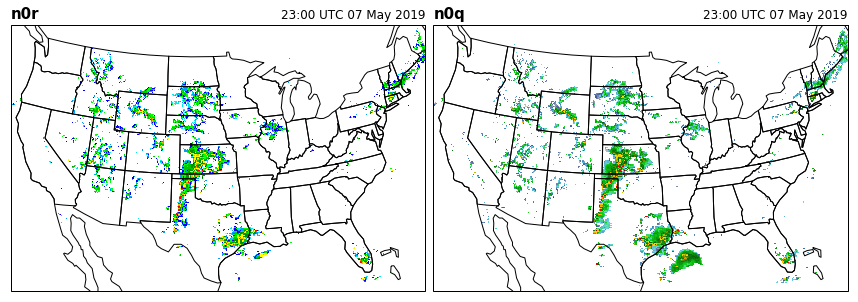

In [65]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.LambertConformal(central_longitude=-100))
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.LambertConformal(central_longitude=-100))

ax1.coastlines()
ax2.coastlines()

DATE = datetime(2019, 5, 7, 23)
strDATE = DATE.strftime('%Y-%m-%dT%H:%M:%SZ')

ax1.set_title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
ax1.set_title('n0r', loc='left', fontweight='bold', fontsize=15)
ax1.add_wms(wms='https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?',
            layers='nexrad-n0r-wmst',
            wms_kwargs={'time':strDATE})
                                        
ax2.set_title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
ax2.set_title('n0q', loc='left', fontweight='bold', fontsize=15)
ax2.add_wms(wms='https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0q-t.cgi?',
           layers='nexrad-n0q-wmst',
           wms_kwargs={'time':strDATE})

ax1.set_extent([-120, -75, 23, 50])
ax2.set_extent([-120, -75, 23, 50])

ax1.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.STATES)

fig.subplots_adjust(wspace=0.02)

# Plot an arcgis MapService image

Ok, I am starting to see how `cartopy` is superior to `Basemap`. For the last two years, on of my reason for sticking with basemap was the ease of adding _arc gis_ images as my background. I have finally figured out how to do this with `cartopy`. And I might add, cartopy is better than Basemap in this regard becuase it can deal with different projections. Basemap can only add arcgis images to cylindrical projections, but below I show the images added to a PlateCarree and a InterruptedGoodeHomolosine projection. Incredible!

In [4]:
import cartopy
import cartopy.io.img_tiles as cimgt

In [158]:
statmen = cimgt.StamenTerrain(style='terrain')

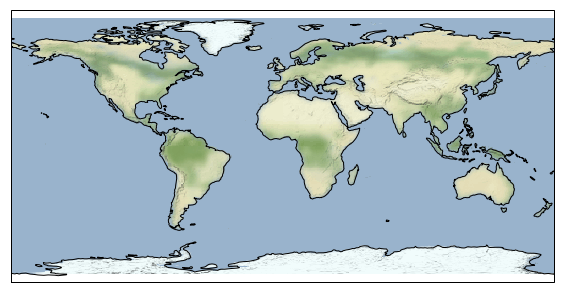

In [159]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_image(statmen, 1)
#ax.add_image(MapQuestOpenAerial(), 2)

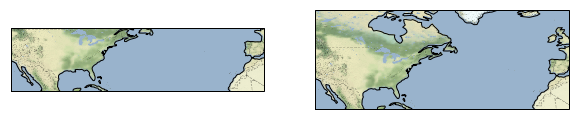

In [164]:
# When I use a PlateCarree project and set_extent crosses the
# prime meridian, the image is distorted.

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax1.coastlines()
ax1.add_image(statmen, 3)
ax1.set_extent([-120, -10, 20, 50], crs=ccrs.PlateCarree())

ax2.coastlines()
ax2.add_image(statmen, 3)
ax2.set_extent([-120, -10, 20, 50])

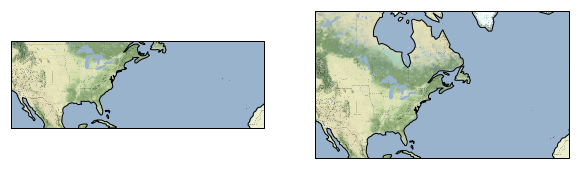

In [165]:
# Projection with statmen projection

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=statmen.crs)
ax2 = fig.add_subplot(1, 2, 2, projection=statmen.crs)

ax1.coastlines()
ax1.add_image(statmen, 4)
ax1.set_extent([-120, -10, 20, 50], crs=ccrs.PlateCarree())

ax2.coastlines()
ax2.add_image(statmen, 4)
ax2.set_extent([-120, -10, 20, 50])

In [10]:
WSR = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

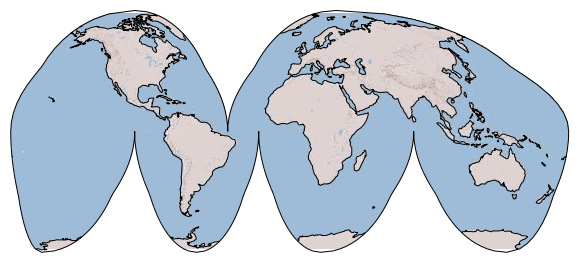

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.InterruptedGoodeHomolosine())
ax.coastlines()
ax.add_image(WSR, 1)

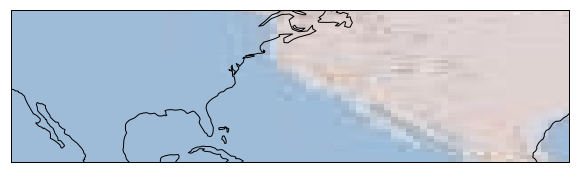

In [46]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_image(WSR, 1)

ax.set_extent([-120, -10, 20, 50], crs=ccrs.PlateCarree())

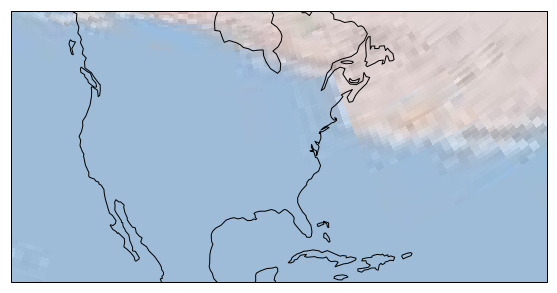

In [64]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.coastlines()
ax.add_image(WSR, 1)

ax.set_extent([-130, -40, 20, 50], crs=ccrs.PlateCarree())

In [141]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

arcgis_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg'
tiles = cimgt.GoogleTiles(url=arcgis_url)

In [143]:
tiles.crs

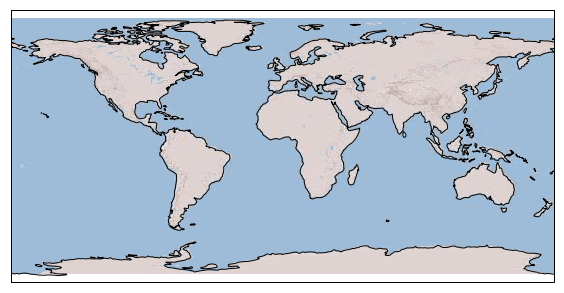

In [66]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_image(tiles,1)

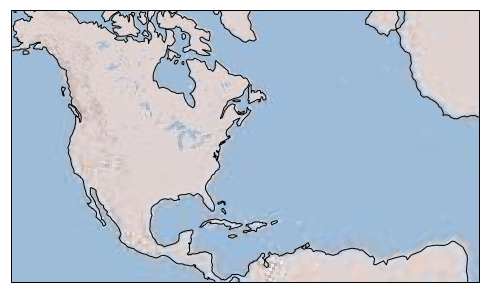

In [67]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.coastlines()
ax.add_image(tiles,1)
ax.set_extent([-130, -10, 10, 50], crs=ccrs.PlateCarree())

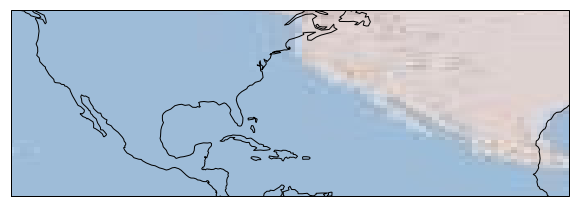

In [70]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-130, -10, 10, 50], crs=ccrs.PlateCarree())
ax.add_image(tiles,1)


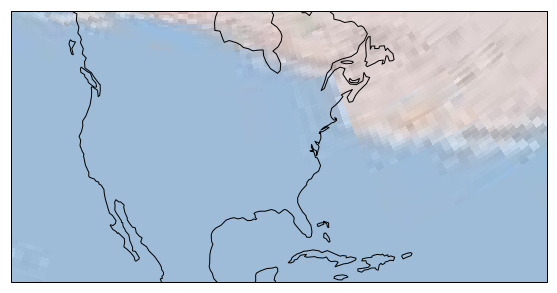

In [69]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.coastlines()
ax.add_image(tiles,1)
ax.set_extent([-130, -40, 20, 50], crs=ccrs.PlateCarree())

In [140]:
tiles

NameError: name 'tiles' is not defined

# ArcGIS tile example:
From: https://stackoverflow.com/questions/37423997/cartopy-shaded-relief

NOTE: Zooming only seems to work with Mercator projection

In [3]:
#import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

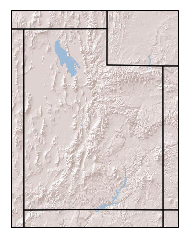

In [4]:
import matplotlib.pyplot as plt
ax = plt.axes(projection=ShadedReliefESRI().crs)

ax.add_image(ShadedReliefESRI(), 7)
ax.set_extent([-114.5, -108.5, 36.5, 42.5])
ax.add_feature(cfeature.STATES)

In [10]:
ShadedReliefESRI._image_url

<function __main__.ShadedReliefESRI._image_url(self, tile)>

In [48]:
class Complex:
    def __init__(self, realpart, imagpart):
        self.r = realpart
        self.i = imagpart

In [50]:
x = Complex(3, -4.5)

In [53]:
x.r, x.i

(3, -4.5)

In [103]:
class Dog:

    def __init__(self, name):
        self.name = name
        self.tricks = []    # creates a new empty list for each dog

    def add_trick(self, trick):
        if trick not in self.tricks:
            self.tricks.append(trick)
        

In [104]:
d = Dog('Fido')

In [110]:
d.add_trick('speak')
d.add_trick('speak')
d.add_trick('speak')

d.add_trick('hi')

d.add_trick('roll')

In [109]:
d.tricks

['speak', 'hi', 'rol']

In [111]:
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

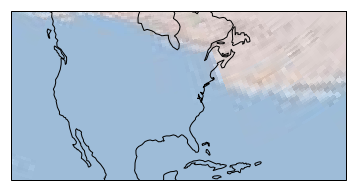

In [139]:
#ax = plt.axes(projection=ShadedReliefESRI().crs)
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-100))
#ax.set_extent([-22, -15, 63, 65])
ax.set_extent([-130, -40, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_image(ShadedReliefESRI(), 1)

In [129]:
ShadedReliefESRI().url

'https://mts0.google.com/vt/lyrs={style}@177000000&hl=en&src=api&x={x}&y={y}&z={z}&s=G'

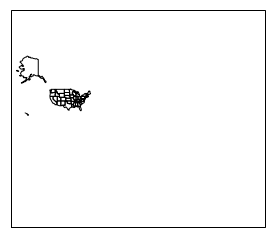

In [146]:

ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(cfeature.STATES)